In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 5000)
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import scipy
import scipy.stats as stats
import shap

In [ ]:
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , ElasticNet , Lasso , Ridge
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Final project CoderSchool - Nam Nguyen/bodyfat.csv')

NameError: name 'pd' is not defined

In [ ]:
pd.options.display.float_format = "{:.4f}".format

# Exploring data

In [ ]:
data

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3000,23,154.2500,67.7500,36.2000,93.1000,85.2000,94.5000,59.0000,37.3000,21.9000,32.0000,27.4000,17.1000
1,1.0853,6.1000,22,173.2500,72.2500,38.5000,93.6000,83.0000,98.7000,58.7000,37.3000,23.4000,30.5000,28.9000,18.2000
2,1.0414,25.3000,22,154.0000,66.2500,34.0000,95.8000,87.9000,99.2000,59.6000,38.9000,24.0000,28.8000,25.2000,16.6000
3,1.0751,10.4000,26,184.7500,72.2500,37.4000,101.8000,86.4000,101.2000,60.1000,37.3000,22.8000,32.4000,29.4000,18.2000
4,1.0340,28.7000,24,184.2500,71.2500,34.4000,97.3000,100.0000,101.9000,63.2000,42.2000,24.0000,32.2000,27.7000,17.7000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,11.0000,70,134.2500,67.0000,34.9000,89.2000,83.6000,88.8000,49.6000,34.8000,21.5000,25.6000,25.7000,18.5000
248,1.0236,33.6000,72,201.0000,69.7500,40.9000,108.5000,105.0000,104.5000,59.6000,40.8000,23.2000,35.2000,28.6000,20.1000
249,1.0328,29.3000,72,186.7500,66.0000,38.9000,111.1000,111.5000,101.7000,60.3000,37.3000,21.5000,31.3000,27.2000,18.0000
250,1.0399,26.0000,72,190.7500,70.5000,38.9000,108.3000,101.3000,97.8000,56.0000,41.6000,22.7000,30.5000,29.4000,19.8000


In [ ]:
data.isna().sum()

,0
Density,0
BodyFat,0
Age,0
Weight,0
Height,0
Neck,0
Chest,0
Abdomen,0
Hip,0
Thigh,0


# Objective is to predict the body fat based on number of optimal features

## 1/Checking Multicollinearity and outliers through heat map and box/dist plots

###Heatmap

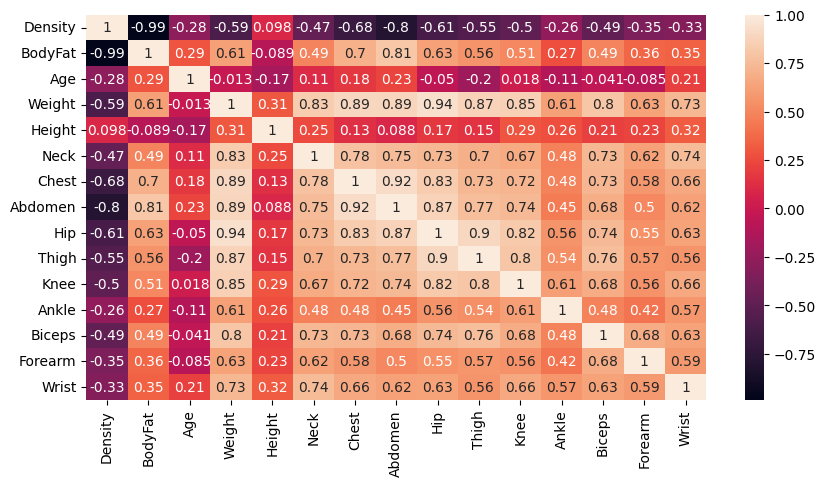

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(),annot=True)
plt.show()

There is Multicollinearity in this dataset --> remove those columns for adjustments (pending)

###Box/Dist for skewed data and outliers

In [ ]:
fig,ax = plt.subplots(15,2,figsize=(10,30))
for index,i in enumerate(data.columns):
    sns.distplot(data[i],ax=ax[index,0],color = 'khaki')
    sns.boxplot(data[i],ax=ax[index,1],color = 'khaki')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle("Visualizing Continuous Columns",fontsize=50)

Lots of them are skewed and have outliers

removing outliers: zscore (done); Skewed data--> log transformation: pending

OR use Box-Cox transformation

**Log transformation**

In [ ]:
'''
data[['Height', 'Hip','Ankle','Weight']].apply(lambda x: np.log(x))
data['Height'] = np.log(data['Height'])
'''

"\ndata[['Height', 'Hip','Ankle','Weight']].apply(lambda x: np.log(x))\ndata['Height'] = np.log(data['Height'])\n"

In [ ]:
x = data.drop(['Density','BodyFat'],axis = 1)
y = data['BodyFat']

###Exclude outliers

In [ ]:
from scipy.special import y0
z = np.abs(stats.zscore(x))

#only keep rows in dataframe with all z-scores less than absolute value of 3
x = x[(z<3).all(axis=1)]
y = y[(z<3).all(axis=1)]
x.shape

(243, 13)

### Feature Engineering

In [ ]:
x['BMI'] = (x['Weight']/2.205)/((x['Height']*2.5/100)**2)
x.drop(['Weight','Height','Ankle','Hip'],axis =1,inplace=True)
x

,Age,Neck,Chest,Abdomen,Thigh,Knee,Biceps,Forearm,Wrist,BMI
0,23,36.2000,93.1000,85.2000,59.0000,37.3000,32.0000,27.4000,17.1000,24.3847
1,22,38.5000,93.6000,83.0000,58.7000,37.3000,30.5000,28.9000,18.2000,24.0829
2,22,34.0000,95.8000,87.9000,59.6000,38.9000,28.8000,25.2000,16.6000,25.4601
3,26,37.4000,101.8000,86.4000,60.1000,37.3000,32.4000,29.4000,18.2000,25.6815
4,24,34.4000,97.3000,100.0000,63.2000,42.2000,32.2000,27.7000,17.7000,26.3360
...,...,...,...,...,...,...,...,...,...,...
247,70,34.9000,89.2000,83.6000,49.6000,34.8000,25.6000,25.7000,18.5000,21.7008
248,72,40.9000,108.5000,105.0000,59.6000,40.8000,35.2000,28.6000,20.1000,29.9791
249,72,38.9000,111.1000,111.5000,60.3000,37.3000,31.3000,27.2000,18.0000,31.1089
250,72,38.9000,108.3000,101.3000,56.0000,41.6000,30.5000,29.4000,19.8000,27.8482


## 2/Splitting data and Normalizing data

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)

###MinMaxScaler (One or the other)

In [ ]:
X_train

,Age,Neck,Chest,Abdomen,Thigh,Knee,Biceps,Forearm,Wrist,BMI
102,41,36.3000,96.7000,89.2000,60.0000,38.4000,31.0000,29.2000,18.4000,24.6922
146,24,39.2000,102.0000,99.1000,71.2000,43.5000,36.1000,30.3000,18.7000,28.5859
199,43,37.4000,103.7000,89.7000,58.5000,39.0000,33.8000,28.8000,18.8000,27.1935
72,56,36.4000,93.6000,82.9000,52.9000,37.5000,29.7000,27.3000,18.2000,21.4456
124,50,37.7000,98.9000,84.1000,58.5000,36.6000,34.4000,29.2000,18.0000,26.4176
...,...,...,...,...,...,...,...,...,...,...
111,43,37.1000,108.0000,105.0000,63.7000,40.0000,33.5000,27.8000,17.4000,27.1368
14,35,40.5000,101.3000,96.4000,69.0000,39.0000,36.1000,30.5000,18.2000,28.2047
97,50,38.7000,99.4000,86.7000,62.1000,39.3000,30.6000,27.8000,18.2000,26.6638
186,41,41.9000,117.5000,109.3000,67.7000,41.3000,37.2000,31.8000,20.0000,30.6343


In [ ]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train


array([[0.3220339 , 0.44444444, 0.41134752, ..., 0.57009346, 0.47916667,
        0.30179166],
       [0.03389831, 0.69230769, 0.53664303, ..., 0.6728972 , 0.54166667,
        0.49453749],
       [0.3559322 , 0.53846154, 0.57683215, ..., 0.53271028, 0.5625    ,
        0.42561019],
       ...,
       [0.47457627, 0.64957265, 0.4751773 , ..., 0.43925234, 0.4375    ,
        0.39938879],
       [0.3220339 , 0.92307692, 0.90307329, ..., 0.81308411, 0.8125    ,
        0.59594   ],
       [0.50847458, 0.93162393, 0.72576832, ..., 0.60747664, 0.625     ,
        0.4037346 ]])

### Box Cox Transformation (if Box Cox then no minmax but not sure how it works)

In [ ]:
'''
box = PowerTransformer(method='yeo-johnson')
X_train = box.fit_transform(X_train)
X_test = box.transform(X_test)
'''

"\nbox = PowerTransformer(method='yeo-johnson')\nX_train = box.fit_transform(X_train)\nX_test = box.transform(X_test)\n"



```
box = PowerTransformer(method='box-cox')
X_train = box.fit_transform(X_train)
X_test = box.transform(X_test)
X_train
data = pd.DataFrame(X_train)
data
```



In [ ]:
X_train

array([[0.3220339 , 0.44444444, 0.41134752, ..., 0.57009346, 0.47916667,
        0.30179166],
       [0.03389831, 0.69230769, 0.53664303, ..., 0.6728972 , 0.54166667,
        0.49453749],
       [0.3559322 , 0.53846154, 0.57683215, ..., 0.53271028, 0.5625    ,
        0.42561019],
       ...,
       [0.47457627, 0.64957265, 0.4751773 , ..., 0.43925234, 0.4375    ,
        0.39938879],
       [0.3220339 , 0.92307692, 0.90307329, ..., 0.81308411, 0.8125    ,
        0.59594   ],
       [0.50847458, 0.93162393, 0.72576832, ..., 0.60747664, 0.625     ,
        0.4037346 ]])

## 3/Modelling and finding feature importance

**Before using feature importance**

In [ ]:
from sklearn.linear_model import LinearRegression , ElasticNet , Lasso , Ridge
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge

In [ ]:
lgbm = LGBMRegressor()
random = RandomForestRegressor()
linear = LinearRegression()
ridge = Ridge()
svr=SVR()
grad = GradientBoostingRegressor()
bay = BayesianRidge()
lr = LogisticRegression()

In [ ]:
def compute(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    hashmap[str(model)]=(r2,rmse)

In [ ]:
clf = [linear,ridge,svr,grad,bay,random,lgbm]
hashmap={}
for i in clf:
    compute(i)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 475
[LightGBM] [Info] Number of data points in the train set: 182, number of used features: 10
[LightGBM] [Info] Start training from score 19.200549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
score=pd.DataFrame(hashmap)
score = score.transpose()
score.columns=['R2_score','RMSE']
score = score.sort_values('R2_score',ascending=False)
score

,R2_score,RMSE
BayesianRidge(),0.7162,4.1579
LinearRegression(),0.7160,4.1589
Ridge(),0.6937,4.3194
RandomForestRegressor(),0.6559,4.5782
LGBMRegressor(),0.6366,4.7043
GradientBoostingRegressor(),0.6119,4.8621
SVR(),0.5287,5.3579


In [ ]:
y_pred = bay.predict(X_test)
sns.scatterplot(y_test,y_pred)
plt.plot([5,35], [5,35], color = 'red',linestyle='--',linewidth=1)
plt.xlabel("Actual-->")
plt.ylabel("Predicted-->")
plt.title("Actual Vs Predicted")

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

### 3a/Feature importance (Linear regression)

In [ ]:
importance = linear.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature imp  ortance
from matplotlib import pyplot
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

so Age, Abdomen, Thigh, Ankle, Biceps, Forearm are important features.

In [ ]:
x

**remove unnecessary columns**

In [ ]:
x1 = x.drop(['Neck','Chest','Knee',	'Biceps',	'Forearm','Wrist','Age','Thigh'],axis = 1)

### 3b/Splitting and Modelling again

In [ ]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(x1,y,test_size=0.25,random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)
X_train1

In [ ]:
def compute(model):
    model.fit(X_train1,y_train1)
    y_pred1 = model.predict(X_test1)
    r2=r2_score(y_test1,y_pred1)
    rmse=np.sqrt(mean_squared_error(y_test1,y_pred1))
    hashmap[str(model)]=(r2,rmse)

In [ ]:
clf = [linear,ridge,svr,grad,bay,random,lgbm]
hashmap={}
for i in clf:
    compute(i)

In [ ]:
score=pd.DataFrame(hashmap)
score = score.transpose()
score.columns=['R2_score','RMSE']
score = score.sort_values('R2_score',ascending=False)
score

In [ ]:
y_pred1 = linear.predict(X_test1)
sns.scatterplot(y_test,y_pred1)
plt.plot([1.02, 1.10], [1.02, 1.10], color = 'red',linestyle='--',linewidth=1)
plt.xlabel("Actual-->")
plt.ylabel("Predicted-->")
plt.title("Actual Vs Predicted")

### 3c/Feature importance (Random forest)

In [ ]:
importance1 = random.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

##Intepreting Values


In [ ]:
cv_scores = cross_val_score(gbc, X_train, Y_train, cv=5, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

how to save and deploy the model